In [30]:
# Install and import library

# !pip3 install yfinance
# pip install cvxopt

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt as opt
from cvxopt import blas, solvers, matrix

In [31]:
# Load stock data

symbols = ['MSFT', 'AMZN', 'AAPL', 'GOOGL', 'META']
start_date = '2020-01-01'
end_date = '2024-04-01'

stock_data = yf.download(symbols, start_date, end_date)['Adj Close']

[*********************100%%**********************]  5 of 5 completed


<Figure size 1200x600 with 0 Axes>

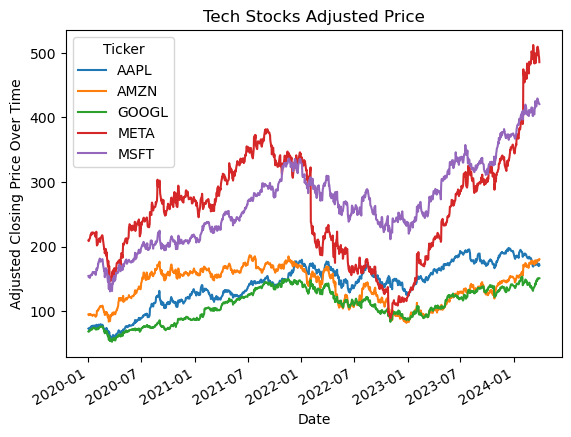

In [32]:
# Plot adjusted closing prices
plt.figure(figsize=(12, 6))
stock_data.plot()
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price Over Time')
plt.title('Tech Stocks Adjusted Price')
plt.savefig('Tech Stocks Adjusted Price.png')
plt.show()

<Figure size 1200x600 with 0 Axes>

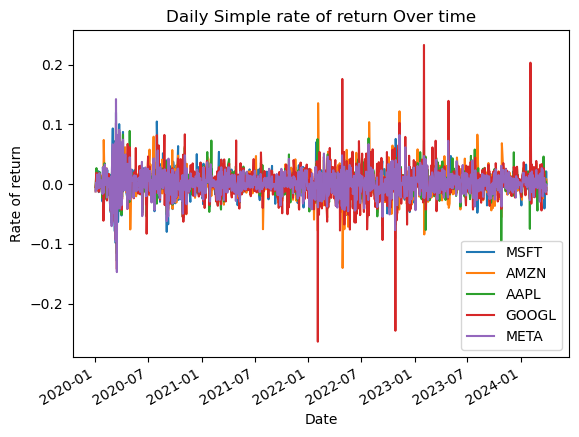

In [33]:
# Calculate and plot the daily simple rate of return
stock_data_daily_returns = stock_data.pct_change()
plt.figure(figsize=(12, 6))
stock_data_daily_returns.plot()
plt.xlabel('Date')
plt.ylabel('Rate of return')
plt.title('Daily Simple rate of return Over time')
plt.legend(symbols)
plt.savefig('Daily Simple rate of return Over time.png')
plt.show()

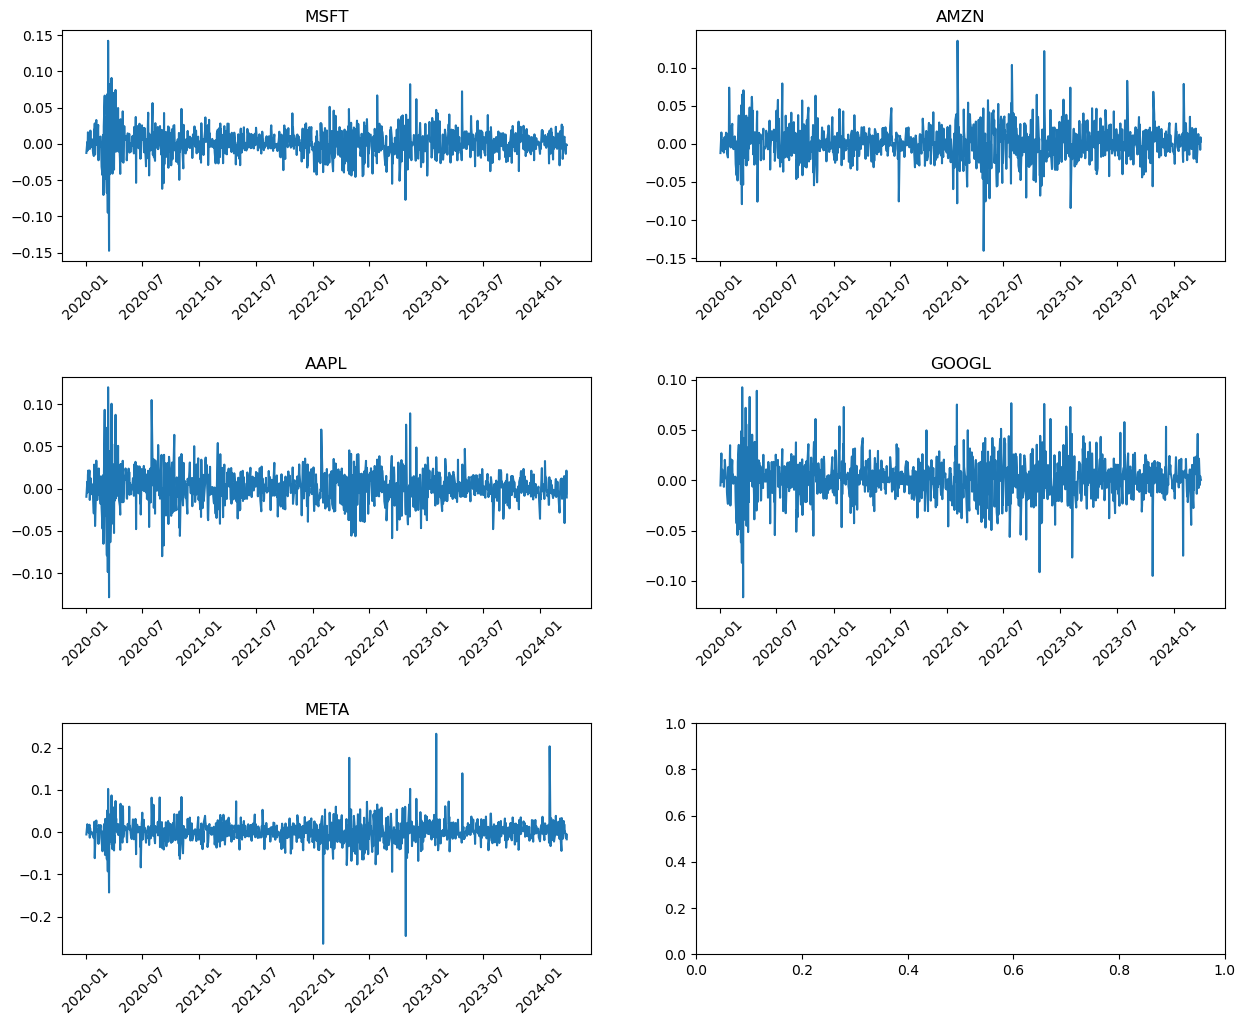

In [34]:
# Subplots of daily simple rate of return
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
for idx, symbol in enumerate(symbols):
    ax = axes[idx//2, idx%2]
    ax.plot(stock_data[symbol].pct_change())
    ax.set_title(symbol)
    ax.tick_params(axis='x', rotation=45)
plt.subplots_adjust(hspace=0.5)
plt.show()

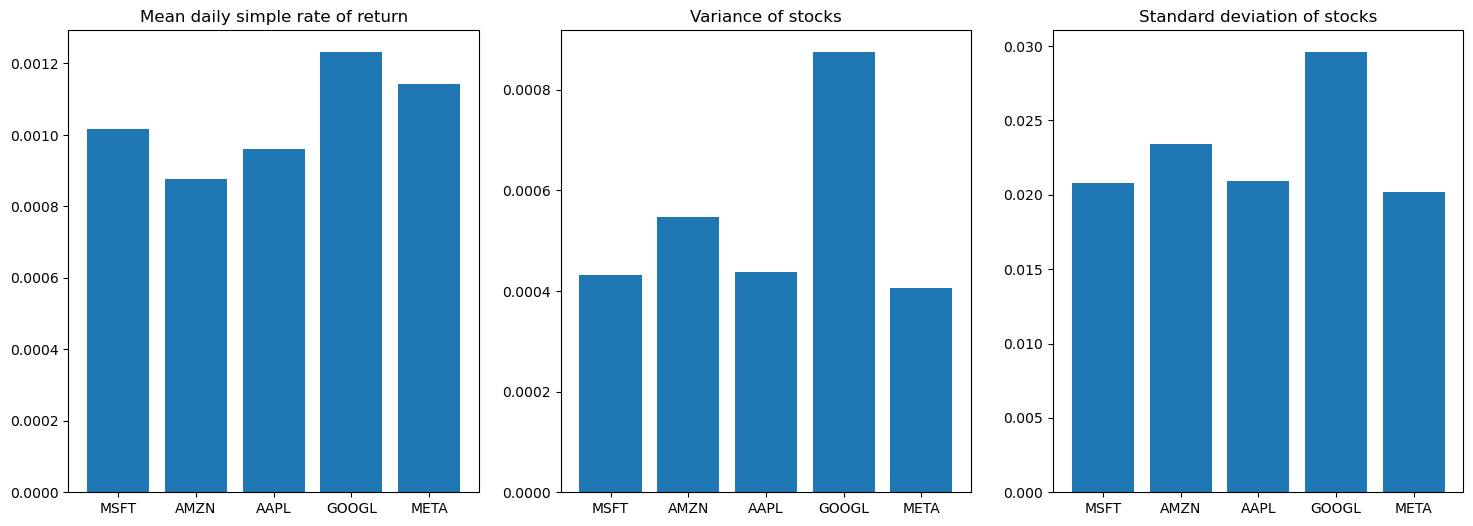

In [35]:
# Plot daily mean, variance, and standard deviation
mean = stock_data_daily_returns.mean()
variance = stock_data_daily_returns.var()
std_dev = stock_data_daily_returns.std()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].bar(symbols, mean)
axes[0].set_title('Mean daily simple rate of return')
plt.savefig('Mean daily simple rate of return.png')

axes[1].bar(symbols, variance)
axes[1].set_title('Variance of stocks')
plt.savefig('Variance of stocks.png')

axes[2].bar(symbols, std_dev)
axes[2].set_title('Standard deviation of stocks')
plt.savefig('Standard deviation of stocks.png')
plt.show()

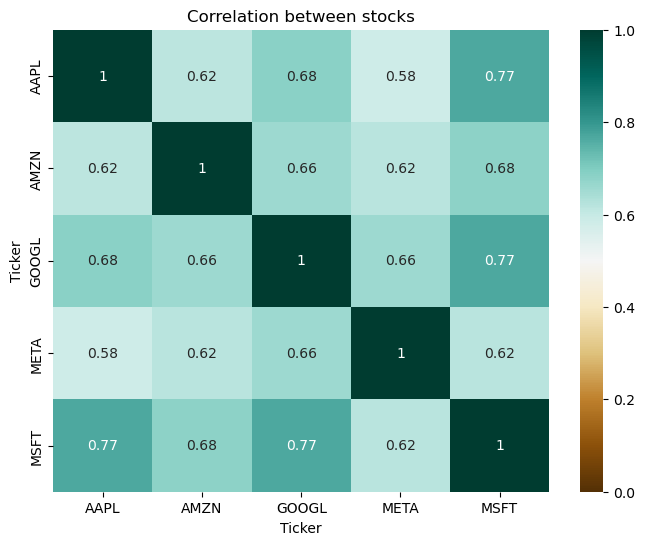

In [36]:
# Calculate and visualize stock correlations with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(stock_data_daily_returns.corr(), vmin=0, vmax=1, annot=True, cmap='BrBG')
plt.title('Correlation between stocks')
plt.savefig('Correlation between stocks.png')
plt.show()

In [37]:
stock_data_daily_returns.corr()

Ticker,AAPL,AMZN,GOOGL,META,MSFT
Ticker,,,,,
AAPL,1.000000,0.615874,0.684848,0.584581,0.768772
AMZN,0.615874,1.000000,0.657025,0.617751,0.680717
GOOGL,0.684848,0.657025,1.000000,0.658678,0.765780
META,0.584581,0.617751,0.658678,1.000000,0.620318
MSFT,0.768772,0.680717,0.765780,0.620318,1.000000


None of the stocks are negatively correlated. Microsoft and Apple have the highest correlation, while Meta and Apple exhibit the lowest correlation.

In [38]:
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df
  
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.to_numpy())

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

     pcost       dcost       gap    pres   dres
 0: -1.0266e-03 -1.0012e+00  1e+00  2e-16  3e+00
 1: -1.0266e-03 -1.1202e-02  1e-02  1e-16  3e-02
 2: -1.0296e-03 -1.3016e-03  3e-04  6e-17  7e-04
 3: -1.1547e-03 -1.1964e-03  4e-05  1e-16  2e-19
 4: -1.1858e-03 -1.1884e-03  3e-06  2e-16  2e-19
 5: -1.1876e-03 -1.1877e-03  3e-08  1e-16  2e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0242e-03 -1.0012e+00  1e+00  2e-16  3e+00
 1: -1.0243e-03 -1.1198e-02  1e-02  5e-17  3e-02
 2: -1.0272e-03 -1.2979e-03  3e-04  1e-16  7e-04
 3: -1.1499e-03 -1.1913e-03  4e-05  1e-16  7e-19
 4: -1.1802e-03 -1.1830e-03  3e-06  2e-16  3e-19
 5: -1.1823e-03 -1.1823e-03  4e-08  1e-16  5e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0216e-03 -1.0012e+00  1e+00  0e+00  3e+00
 1: -1.0217e-03 -1.1194e-02  1e-02  1e-16  3e-02
 2: -1.0246e-03 -1.2939e-03  3e-04  5e-17  7e-04
 3: -1.1446e-03 -1.1857e-03  4e-05  1e-16  6e-19
 4: -1.1741e-03 -1.1771e

 3:  2.3540e-02  2.3378e-02  2e-04  8e-17  4e-05
 4:  2.3436e-02  2.3429e-02  7e-06  1e-16  5e-07
 5:  2.3430e-02  2.3430e-02  7e-08  1e-16  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.9050e-02 -9.7688e-01  1e+00  0e+00  3e+00
 1:  2.8936e-02  1.3238e-02  2e-02  2e-16  4e-02
 2:  2.7170e-02  2.5489e-02  2e-03  2e-16  3e-03
 3:  2.6527e-02  2.6364e-02  2e-04  8e-17  3e-05
 4:  2.6419e-02  2.6413e-02  6e-06  2e-16  4e-07
 5:  2.6413e-02  2.6413e-02  6e-08  1e-16  4e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.2680e-02 -9.7389e-01  1e+00  0e+00  3e+00
 1:  3.2540e-02  1.6253e-02  2e-02  9e-17  4e-02
 2:  3.0559e-02  2.8827e-02  2e-03  8e-17  3e-03
 3:  2.9876e-02  2.9715e-02  2e-04  6e-17  2e-05
 4:  2.9766e-02  2.9760e-02  6e-06  2e-16  3e-07
 5:  2.9761e-02  2.9761e-02  6e-08  1e-16  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.6744e-02 -9.7053e-01  1e+00  0e+00  3e+00


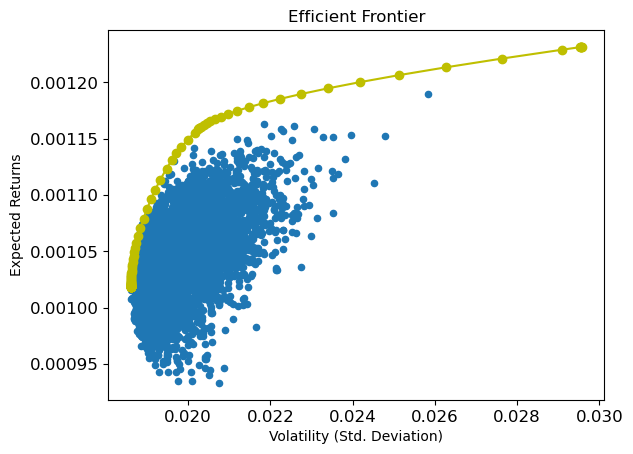

In [39]:
covariance = stock_data_daily_returns.cov()
random_portfolios = return_portfolios(mean, covariance) 
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)


weights, returns, risks = optimal_portfolio(stock_data_daily_returns[1:])
plt.plot(risks, returns, 'y-o')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.savefig('Efficient Frontier.png')
plt.show()

In [40]:
# Define optimal weights of stocks
print("Optimal weights:", weights)

Optimal weights: [[8.94538249e-06]
 [3.99215250e-06]
 [6.50187664e-06]
 [9.99963347e-01]
 [1.72139008e-05]]
